# SCC0277: Desafio de Séries Temporais

Dikson F. Santos `<dikson@usp.br>`

`(github.com/diksown/wind-whisper)`


## Introdução


...


## Pré-processamento


### Inicialização dos dados


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
df = pd.read_csv("data/DailyDelhiClimateTrain.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


Não faltam valores! Maravilha.


In [66]:
df["date"] = pd.to_datetime(df["date"])

## Data visualization


In [67]:
def feature_along_time(df, feature_title, feature_name, unit):
    plt.figure(figsize=(15, 4))
    plt.plot(df["date"], df[feature_name])
    plt.title(feature_title)
    plt.ylabel(unit)
    plt.show()

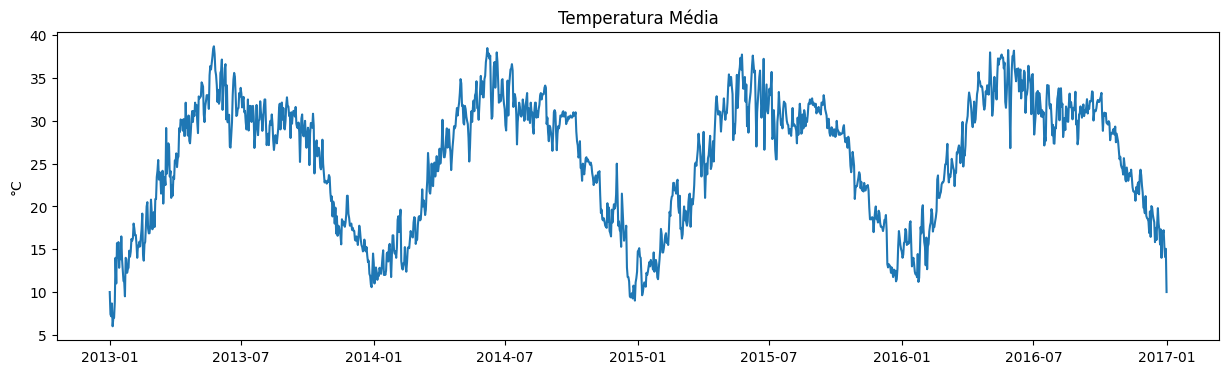

In [68]:
feature_along_time(df, "Temperatura Média", "meantemp", "°C")

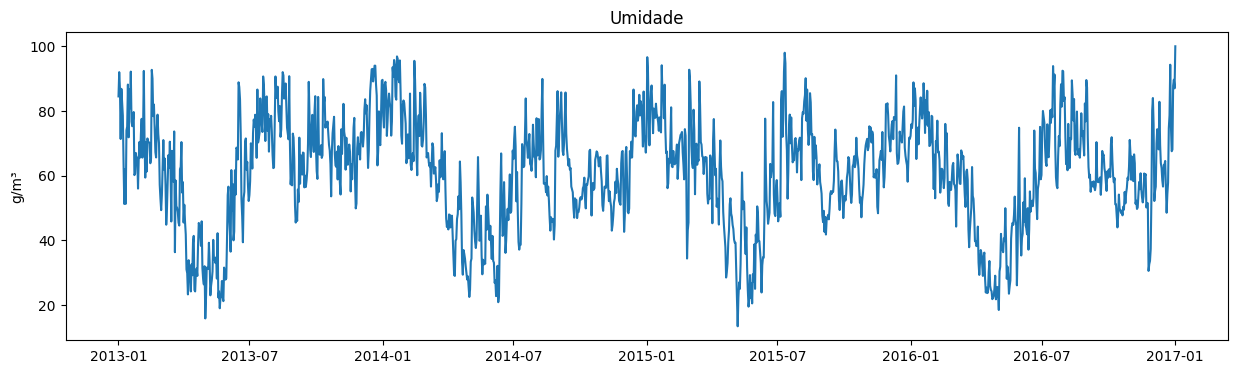

In [69]:
feature_along_time(df, "Umidade", "humidity", "g/m³")

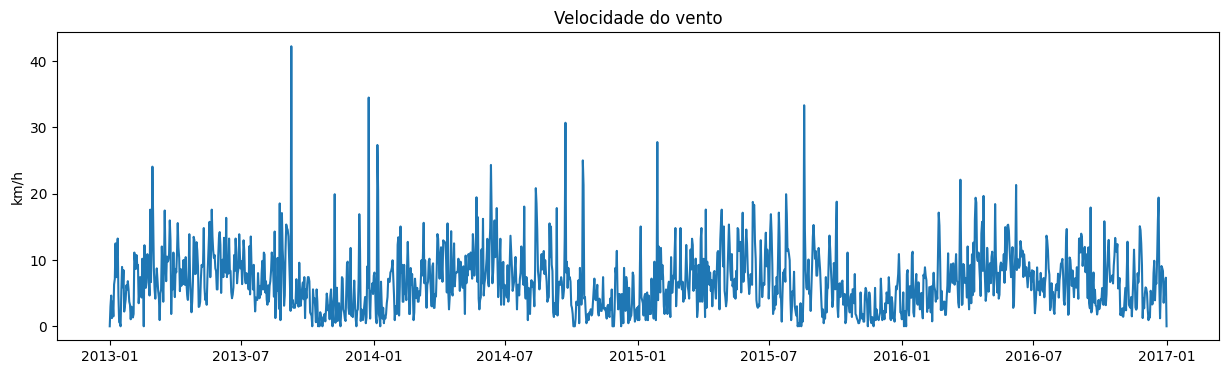

In [70]:
feature_along_time(df, "Velocidade do vento", "wind_speed", "km/h")

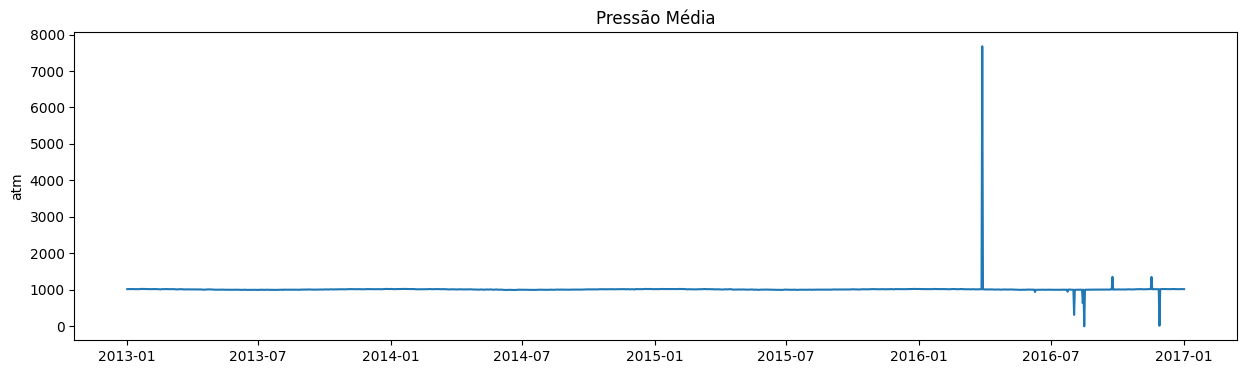

In [71]:
feature_along_time(df, "Pressão Média", "meanpressure", "atm")

## Prediction


## Interpretation


## Conclusion
